# CUSTOMER CHURN PREDICTION

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [21]:
data=pd.read_csv('Churn_Modelling.csv')

In [22]:
data.shape

(10000, 14)

In [23]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [25]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")

RowNumber: 10000
CustomerId: 10000
Surname: 2932
CreditScore: 460
Geography: 3
Gender: 2
Age: 70
Tenure: 11
Balance: 6382
NumOfProducts: 4
HasCrCard: 2
IsActiveMember: 2
EstimatedSalary: 9999
Exited: 2


In [26]:
for col in data.columns:
    print(f"{col}: {data[col].isnull().sum()}")

RowNumber: 0
CustomerId: 0
Surname: 0
CreditScore: 0
Geography: 0
Gender: 0
Age: 0
Tenure: 0
Balance: 0
NumOfProducts: 0
HasCrCard: 0
IsActiveMember: 0
EstimatedSalary: 0
Exited: 0


In [27]:
data = data.drop(columns=['RowNumber', 'CustomerId'])

In [28]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [29]:
non_numeric_cols =data.select_dtypes(include=['object', 'category', 'datetime']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['Surname', 'Geography', 'Gender'], dtype='object')


In [30]:
print(data["Exited"].value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64


In [31]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [32]:
def plot_histogram(data,column_name):
    plt.figure(figsize=(5, 3))
    sns.histplot(data[column_name], kde=True)
    plt.title(f"Distribution of {column_name}")
    
    col_mean = data[column_name].mean()
    col_median = data[column_name].median()
    
    plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
    plt.axvline(col_median, color="green", linestyle="-", label="Median")
    
    plt.legend()
    plt.show()


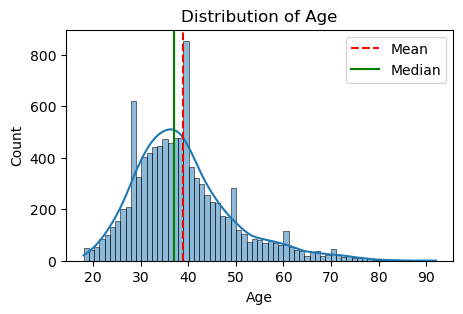

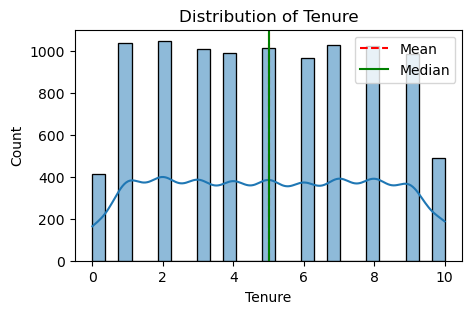

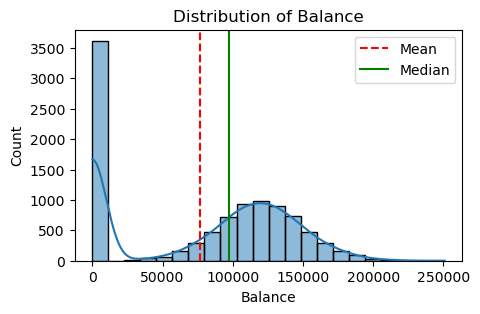

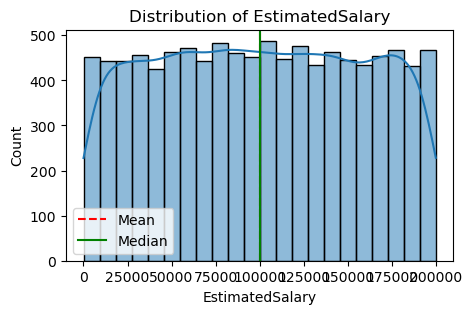

In [33]:
for col in ['Age', 'Tenure', 'Balance', 'EstimatedSalary']:
    plot_histogram(data, col)

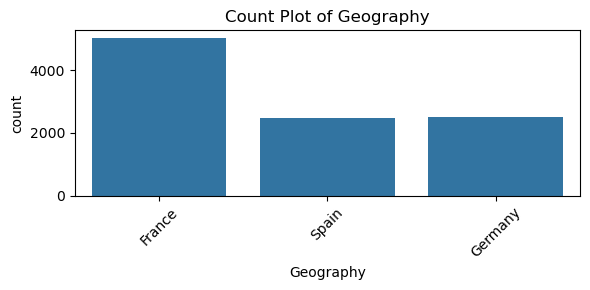

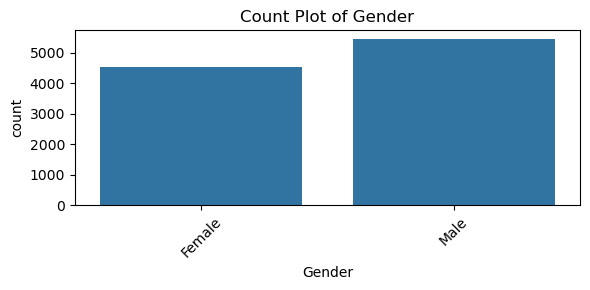

In [34]:
for col in non_numeric_cols:
    if col != 'Surname':
        plt.figure(figsize=(6, 3))
        sns.countplot(x=data[col])
        plt.title(f"Count Plot of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


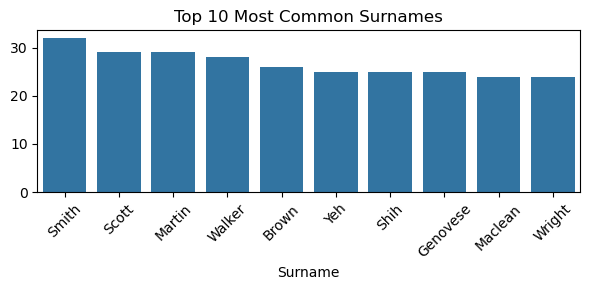

In [35]:
top_surnames = data['Surname'].value_counts().head(10)

plt.figure(figsize=(6, 3))
sns.barplot(x=top_surnames.index, y=top_surnames.values)
plt.title("Top 10 Most Common Surnames")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
le = LabelEncoder()
data['Geography'] = le.fit_transform(data['Geography'])
data['Gender'] = le.fit_transform(data['Gender'])
data['Surname'] = le.fit_transform(data['Surname'])


In [37]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,289,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [38]:
X = data.drop(columns=["Exited"])
y = data["Exited"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
print(y_train.shape)

(8000,)


In [41]:
print(y_train.value_counts())

Exited
0    6356
1    1644
Name: count, dtype: int64


### Synthetic Minority Over-sampling Technique(SMOTE)

In [42]:
smote = SMOTE(random_state=42)

In [43]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [44]:
print(y_train_smote.shape)

(12712,)


In [45]:
print(y_train_smote.value_counts())

Exited
0    6356
1    6356
Name: count, dtype: int64


In [46]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [47]:
cv_scores = {}
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*70)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.79
----------------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.86
----------------------------------------------------------------------
Training XGBoost with default parameters
XGBoost cross-validation accuracy: 0.86
----------------------------------------------------------------------


In [48]:
cv_scores

{'Decision Tree': array([0.70821864, 0.78686591, 0.82258065, 0.80094414, 0.82376082]),
 'Random Forest': array([0.75422729, 0.86590641, 0.90165224, 0.88001574, 0.8945712 ]),
 'XGBoost': array([0.76287849, 0.86511994, 0.89732494, 0.86900079, 0.89339103])}

In [49]:
rfc = RandomForestClassifier(random_state=42)

In [50]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [51]:
print(y_test.value_counts())

Exited
0    1607
1     393
Name: count, dtype: int64


In [52]:
y_test_pred = rfc.predict(X_test)
print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.823
Confsuion Matrix:
 [[1394  213]
 [ 141  252]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1607
           1       0.54      0.64      0.59       393

    accuracy                           0.82      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.84      0.82      0.83      2000

